# User's Manual for Land-Use Trade-Offs II model

LUTO-2 is the second version of the Land-Use Trade-Offs model (hereafter referred to as LUTO). This spatial optimization model comprises five key components and operates under a cost-minimization or profit-maximization logic.

 - Land-Use Map (2010): A baseline map featuring 28 agricultural land-use classes.
 - Productivity Maps: Projections for each land-use class from 2010 to 2100 under various Shared Socioeconomic Pathway (SSP) scenarios.
 - Environmental Impact Maps: Assessments of water use, greenhouse gas (GHG) emissions, and biodiversity impacts for each of the 28 gricultural land-use classes.
 - Food Demand Outlooks: Domestic and global food demand projections.
 - Optimizer: A solution framework that determines strategies to meet water limitations, GHG emissions targets, food demand, and biodiversity objectives. 

The optimization process can be primarily divided into 3 steps:
1) Find the solutions that meet the demand<br>
    `Land-use map` * `Productivity map` >= `Demand`
2) Find the solutions that meet the environmental constraints<br>
    `Land-use map` * `Resource requirement map` <= `Constraint`
3) Maximize profit (or minimize cost) to get the optimal solution<br>
    `Best solution` = `Maximize(Revenue - Cost)` or `Minimize(Cost)`

LUTO is designed as a policy tool to answer 'what-if' questions under major climate change and socio-ecnomicy pathways, as well as Australia's national context. The `Demand` is sourced from external modelling considering Australia's imports, exports, diets, et cetera; the `productivity map` is driven by different climate change predictions; and the `resource requirement map` is acquired through paper review and stakeholder collaborations. Users can specify their assumptions by choosing parameters in the `settings.py` file. 

As an highly optimized model, LUTO rearranges all the input data from 2D-map format into a 1D-array representation to save memory and reduce running time, making it difficult for users to intuitively understand what happened within each process. This manual converts the 1D array back to its original 2D format and visualize the process of arranging land-use map to meet demand targets under water, GHG, and biodiversity constraints.

```{note}
LUTO-2 is capable of running land-use change for Australia at a ~1x1 square kilometer scale, but this chapter will use a setting that specifies `RESFACTOR=5` to reduce processing time. Essentially, this resfactor means we are only using the centroid cell out of each 5*5 square matrix to run the model.
```

Before entering the amazing LUTO world, please keep in mind that this manual tries to explain how LUTO works in the most intuitive way. That means sometimes we may lose technical depth or skip over certain complexities. If you are keen to understand how exactly this model works, we encourage you to look at the source code and delve into the tech/data manual provided under the `/docs`. 

In [ ]:
# REMOVE

'''
Here are the code to run LUTO first, so that we can have the variables and objects required for illustration in the notebook.
'''

# Reload all modules before excuting each cell, so that we can modify the imported custom functions on-the-fly without rerun the whole model.
%load_ext autoreload
%autoreload 2

# Imports
import os
import h5py           
import netCDF4  
from lxml import etree

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as p9
import geopandas as gpd

from rasterstats import zonal_stats
from itertools import product
from tqdm.auto import tqdm

# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


# cd to the root folder of LUTO project
os.chdir('N:/LUF-Modelling/LUTO2_JZ/luto-2.0')
from luto.tools.Manual_jupyter_books.helpers import map_to_4band, mrj_to_xr, arr_to_xr, map_to_plot
from luto.economics.agricultural.quantity import get_quantity_matrices
from luto.economics.agricultural.water import get_wreq_matrices
from luto.tools.Manual_jupyter_books.helpers.parameters import legend_params


# Run LUTO
import luto.simulation as sim
data = sim.load_data()
sim.run(data=data, base=2010, target=2050)

data = data

# Land-use Map and Demand

## Land-use Map of Australia in 2010

LUTO-2 uses the national land-use map of 2010 as the starting point. The map is downloaded from [DAFF](https://www.agriculture.gov.au/abares/aclump/land-use/land-use-mapping) and has several different classification schemes. Because LUTO-2 is an agricultural model, we exclude water and intensive uses (urban built-ups, commercial uses, etc.) from the modeling and created a land-use classification based on the 'PRIMARY_V7' schema of DAFF and a profit map provided by CSIRO. The final land-use map is classified as shown in the below table.

| Code | Description                | Code | Description              | Code | Description                  | Code | Description                 |
|------|----------------------------|------|--------------------------|------|------------------------------|------|-----------------------------|
| -1   | Non Agricultural and       | 7    | Grapes                   | 15   | Sheep - natural land         | 23   | Unallocated - natural land  |
| 0    | Apples                     | 8    | Hay                      | 16   | Stone fruit                  | 24   | Vegetables                  |
| 1    | Beef - modified land       | 9    | Nuts                     | 17   | Sugar                        | 25   | Winter cereals              |
| 2    | Beef - natural land        | 10   | Other non-cereal crops   | 18   | Summer cereals               | 26   | Winter legumes              |
| 3    | Citrus                     | 11   | Pears                    | 19   | Summer legumes               | 27   | Winter oilseeds             |
| 4    | Cotton                     | 12   | Plantation fruit         | 20   | Summer oilseeds              |                                    |
| 5    | Dairy - modified land      | 13   | Rice                     | 21   | Tropical stone fruit         |                                    |
| 6    | Dairy - natural land       | 14   | Sheep - modified land    | 22   | Unallocated - modified land  |                                    |



It is overwhelming to consider all 28 agricultural land-use for illustration. Instead, let's only map the sptail distribution of `Winter cereals` under minimized-cost/maximized-profit drives given various constraints. Referring to table above, we know that the code of 25 is winter cereal. We will use this value to extract the map of winter cereal.

In [2]:
# REMOVE

# Define year, lu_code
year_begin = 2010
year_target = 2050
lu_code = 25 # Winter cereals
lu_desc = data.AGRICULTURAL_LANDUSES[lu_code]

# Parameters to save xarray
output_dir = 'luto/tools/Manual_jupyter_books/outputs'
encoding={'data': {"compression": "gzip", "compression_opts": 9,  "dtype": 'float32'}}

# Get the lumap
lumap = mrj_to_xr(data, data.ag_dvars[year_begin])

lu_arr = lumap.sel(lu=lu_desc)
lu_arr_dry = lu_arr.sel(lm='dry')
lu_arr_irr = lu_arr.sel(lm='irr')

lu_mask = arr_to_xr(data, np.ones_like(lumap)) == 1
lu_area = arr_to_xr(data, data.REAL_AREA)

The same land-use under different water supply management (`dry` or `irrigated`) requires significantly different water consumption and economic investment, which ultimately leads to very different yields. To account for this, LUTO-2 introduces a dry/irrigation map that further classifies agricultural land-use into dry land or irrigated land. In this manual, we will split winter cereals into their corresponding dry and irrigated parts. Additionally, input data such as 'water requirement,' 'GHG release,' and 'cost' are provided with a water supply attribution.



If you have a pair of eagle eyes, you can find that only a very small number of irrigated winter cereal cells are scattered in Victoria.

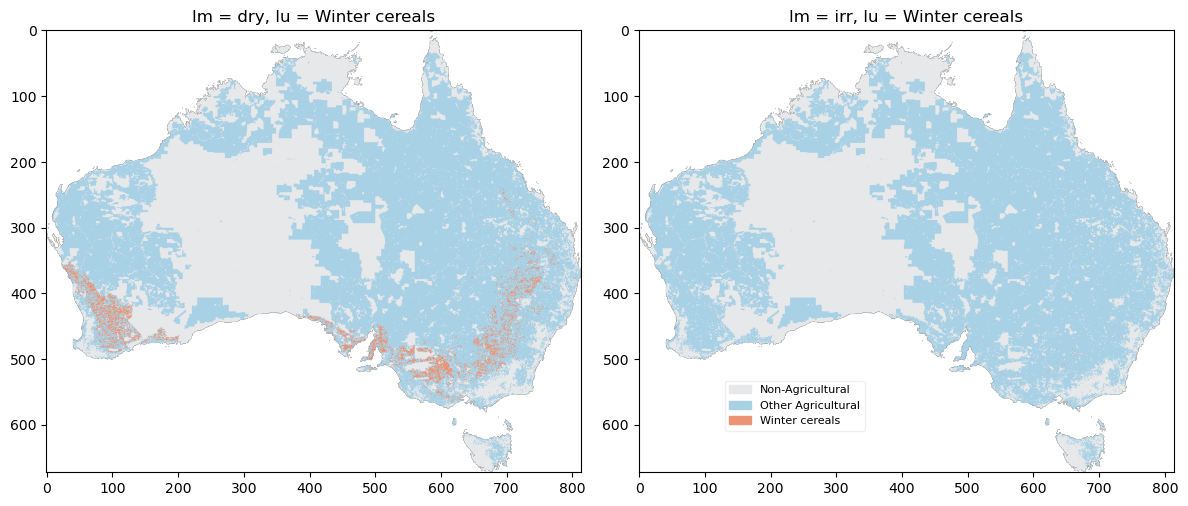

In [3]:
# HIDE CODE

# Get colors/names for pixcels with values of [-1, 0, 1]
colors = [
    (231, 232, 234, 255), # Light grey
    (169, 209, 229, 255), # Light blue
    (236, 147, 116, 255)  # Light red
]

cell_names = [
    'Non-Agricultural', 
    'Other Agricultural', 
    'Winter cereals'
]

# Create a figure and a set of subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first map (dry) on the first axis
map_to_plot(lu_arr_dry, colors, cell_names, legend_params, ax=axs[0])
axs[0].set_title(f'lm = dry, lu = {lu_desc}')

# Plot the second map (irr) on the second axis
map_to_plot(lu_arr_irr, colors, cell_names, legend_params, ax=axs[1])
axs[1].set_title(f'lm = irr, lu = {lu_desc}')

# Optionally, adjust the layout
plt.tight_layout()

# Show the combined plots
plt.show()

Before diving into input data, please keep in mind our objective: find the sptail distribution for winter cereal that is the most cost-minimized/profit-maximized, as well as meeting constraints in water use and GHG emissions.

## Commodity Demands

As an agricultural model, the first target to meet is the food demand. The demand data (tones) is a `pandas.DataFrame` lives in the `data.DEMAND_DATA` variable. We can see that the index of the demand dataframe is commodities, the column is a 2-level column that represents demand compositions and years.

```{note}
The demand includes 'DOMESTIC', 'EXPORTS', 'IMPORTS', 'FEED', 'PRODUCTION', where the 'PRODUCTION' record is the demand data that LUTO needs to meet. The relationship between these compositions is:  
`PRODUCTION` = `DOMESTIC` + `EXPORTS` + `FEED` - `IMPORTS`
```

In [4]:
# HIDE CODE
df = data.DEMAND_DATA
df_styled = df.style.set_table_styles([
    {'selector': 'td', 'props': [('font-size', '10pt')]},
    {'selector': 'th', 'props': [('font-size', '10pt')]}
]).format(precision=2)

df_styled

```{note}
If you have a close look at the `COMMODITY` index, you can find that index items are all lower-case. In addition, there are 32 commodities in total (remember there are only 28 land-uses). Why lower case and 2 more commodities? Carefully observe the table below that shows the mismatched land-use and commodities. Think of the reason by yourself; the answer is in the below explanation.
```

| Land-use                      | Comodity                          |
|-------------------------------|-----------------------------------|
| Beef - modified land          | beef lexp, beef meat              |
| Beef - natural land           | beef lexp, beef meat              |
| Dairy - modified land         | dairy                             |
| Dairy - natural land          | dairy                             |
| Unallocated - modified land   | -                                 |
| Unallocated - natural land    | -                                 |
| Sheep - modified land         | beef lexp, sheep meat, sheep wool |
| Sheep - natural land          | beef lexp, sheep meat, sheep wool |
| -                             | aquaculture                       |
| -                             | chicken                           |
| -                             | eggs                              |
| -                             | pork                              |

The design of using "lower case" for commodity names helps differentiate between "Land-use," "Product," and "Commodity." For example, land designated as "Apple" can only produce apples, whereas both "Beef - modified land" and "Beef - natural land" can produce beef for live export and beef meat. This mismatch between land types and the products they generate requires careful consideration. To address this, we use first-letter-capitalized names to indicate land-use types, all-lowercase names for products derived from the land, and all-uppercase names to refer to specific commodities.

The reason for the inclusion of "4 additional commodities" is that there are four commodities—aquaculture, chicken, eggs, and pork—that cannot be produced from any land use. While the answer is straightforward, it raises a challenge: if there are four commodities that cannot be produced by any land use, how can LUTO meet these demands through land-use distribution? LUTO addresses this by assuming that the demand for these four commodities will be met by the target year. The model then focuses on arranging land use to mitigate their environmental impacts. For instance, if meeting the demand for eggs in 2030 results in 500 kt of GHG emissions, LUTO will aim to plant more trees to sequester the carbon. By considering both on-land (commodities produced directly from land) and off-land (commodities produced from cages or factories), LUTO presents a more comprehensive agricultural model.

In this manual, we are only concerned with winter cereal produced from `Winter Cereal` land-use, which yields a single product: `winter cereal`. Therefore, we only need to examine the data.DEMAND_DATA variable to determine the future demand for this product.

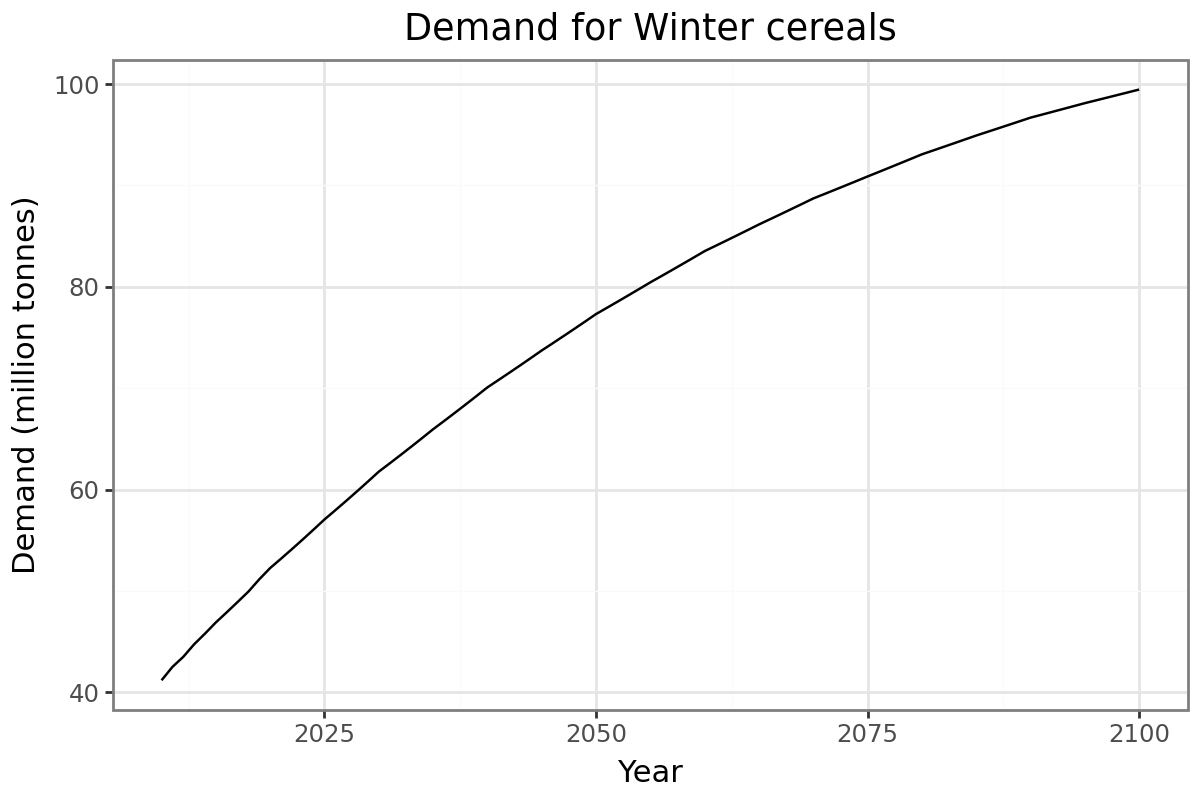

In [5]:
# HIDE CODE
p9.options.figure_size = (6, 4)
p9.options.dpi = 100

# Get the demand data
demand_df = data.DEMAND_DATA.unstack().reset_index()
demand_df.columns = ['Type', 'Year', 'Commodity', 'Value']


# Get the demand for the selected land use
demand_lu = demand_df.query('Type == "PRODUCTION" and Commodity == @lu_desc.lower()')


# Plot the demand
fig = (p9.ggplot(demand_lu, p9.aes(x='Year', y='Value'))
    + p9.geom_line()
    + p9.theme_bw()
    + p9.labs(title=f'Demand for {lu_desc}', x='Year', y='Demand (million tonnes)')
    + p9.scale_y_continuous(labels=lambda f: [f'{x / 1e6:.0f}' for x in f])
    )

fig

Let's query the demand data for year 2050 and get the target to meet.

In [6]:
# HIDE CODE
# Get the demand for the target year
demand_vol = demand_lu.query('Year == @year_target')['Value'].values[0] / 1e6  # Million tonnes

print(f'The demand for {lu_desc} in {year_target} is {demand_vol:.2f} million tonnes.')

The demand for Winter cereals in 2050 is 77.31 million tonnes.


::::{important} 
Differences in diets, exports, and economic conditions can affect food demand, so it is important to consider how these factors impact it. Fortunately, LUTO provides several options to select different scenarios based on our interests. For example, if we want to model a scenario with halved food waste, we simply need to set the `settings.WASTE` parameter to 0.5. 
::::

There are 7 parameters to determine a demand projection, we can change them to fit our anticipation of the future. We can always check the parameters used by printing out `setting.para_name`. This manual uses `SCENARIO=SSP2`, `DIET_DOM='BAU'`, `DIET_GLOB='BAU'`, `CONVERGENCE=2050`, `IMPORT_TREND='Static'`, `WASTE=1`, `FEED_EFFICIENCY='BAU'`. More choices can by found in the below table.         
 

| Parameter         | Values                          | Note                                                                                                                            |
|-------------------|---------------------------------|---------------------------------------------------------------------------------------------------------------------------------|
| SCENARIO          | SSP1, SSP2, SSP3, SSP4, SSP5    |                                                                                                                                 |
| DIET_DOM          | BAU, FLX, VEG, VGN              | 'BAU', 'FLX', 'VEG', 'VGN' - domestic diets in Australia                                                                        |
| DIET_GLOB         | BAU, FLX, VEG, VGN              | 'BAU', 'FLX', 'VEG', 'VGN' - global diets                                                                                       |
| CONVERGENCE       | 2050, 2100                      | 2050 or 2100 - date at which dietary transformation is completed (velocity of transformation)                                   |
| IMPORT_TREND      | Static, Trend                   | 'Static' assumes 2010 shares of imports for each commodity or 'Trend' follows historical rate of change in shares of imports    |
| WASTE             | 0.5, 1.0                        | 1 for full waste, 0.5 for half waste                                                                                            |
| FEED_EFFICIENCY   | BAU, High                       | 'BAU' or 'High'                                                                                                                 |



As an illustration, here is the demand for winter cereal under different domestic diets and food waste levels. It shows that socioeconomic settings have significant influences on demand, and food waste level is a much smaller impact factor.

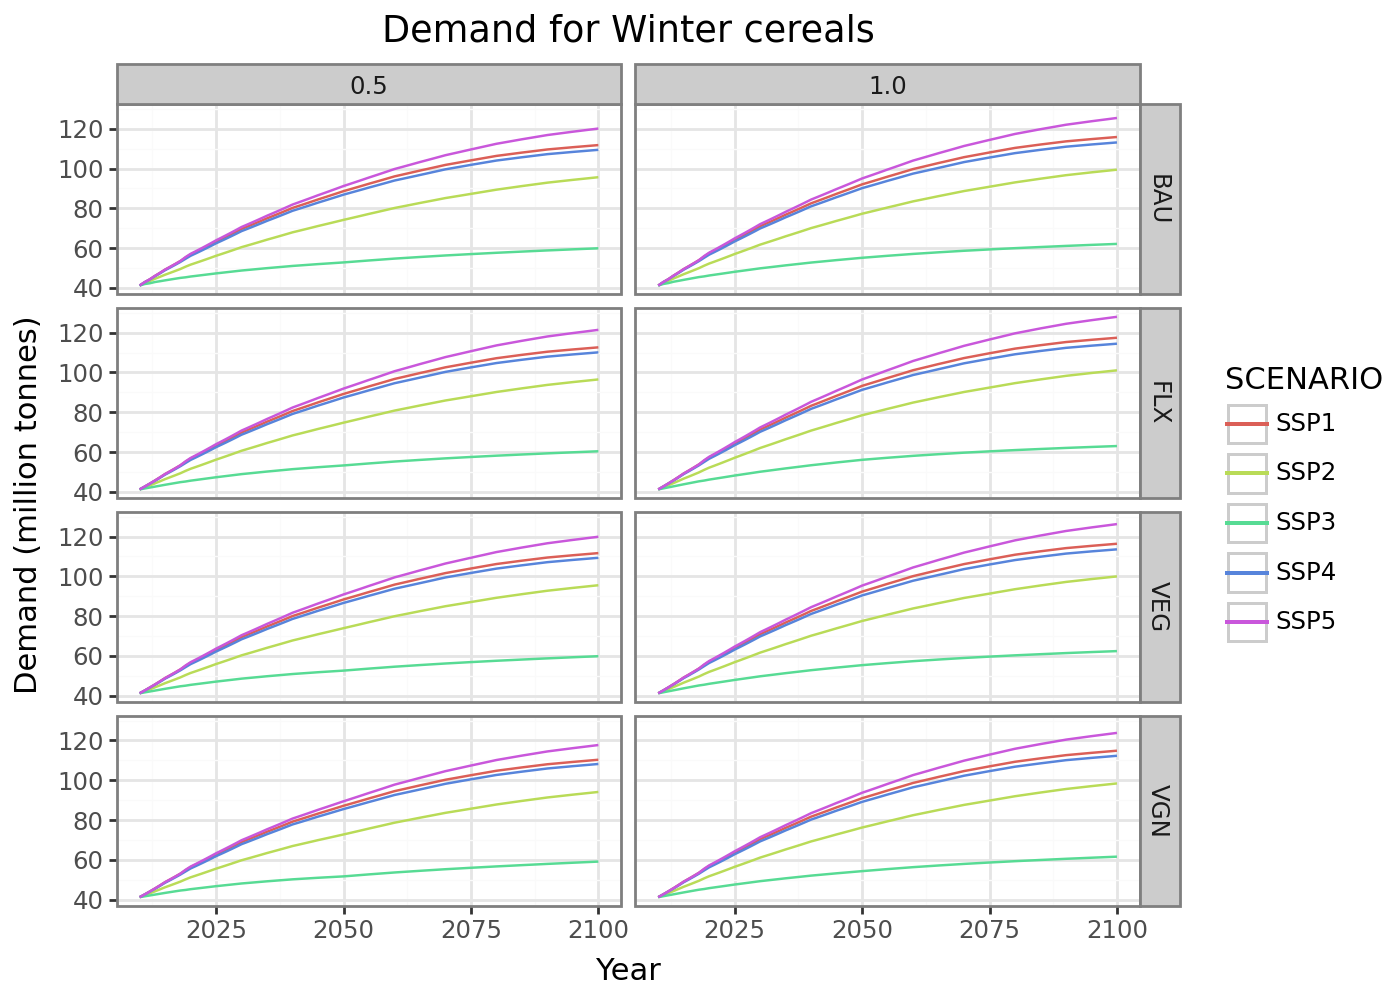

In [7]:
# HIDE CODE


# Get all demand 
dd = pd.read_hdf(os.path.join('input', 'demand_projections.h5') )
dd_long = dd['PRODUCTION'].stack().reset_index().rename(columns={0: 'DEMAND_TONNES'})

# Filter the demand data
commodity = lu_desc.lower()
diet_glob = 'BAU'
conv = 2050
import_t = 'Static'
feed_ef = 'BAU'
d = dd_long.query('COMMODITY == @commodity and DIET_GLOB == @diet_glob and CONVERGENCE == @conv and IMPORT_TREND == @import_t and FEED_EFFICIENCY == @feed_ef')


# Plot the demand under Diet~Waste scenarios
p9.options.figure_size = (7, 5)
p9.options.dpi = 100

fig = (p9.ggplot(d, p9.aes(x='YEAR', y='DEMAND_TONNES', color='SCENARIO'))
     + p9.geom_line()
     + p9.theme_bw()
     + p9.labs(title=f'Demand for {lu_desc}', x='Year', y='Demand (million tonnes)')
     + p9.scale_y_continuous(labels=lambda f: [f'{x / 1e6:.0f}' for x in f])
     + p9.facet_grid('DIET_DOM~WASTE')
    )

fig

OK, now that we know that LUTO needs to produce 77.31 million tonnes of winter cereal in 2050, let's see how it will arrange the spatial distributions to meet this goal.

In [134]:
len(data.LU_MODIFIED_LAND)

24

In [133]:
np.array(data.AGRICULTURAL_LANDUSES)[data.LU_MODIFIED_LAND]

array(['Apples', 'Beef - modified land', 'Citrus', 'Cotton',
       'Dairy - modified land', 'Grapes', 'Hay', 'Nuts',
       'Other non-cereal crops', 'Pears', 'Plantation fruit', 'Rice',
       'Sheep - modified land', 'Stone fruit', 'Sugar', 'Summer cereals',
       'Summer legumes', 'Summer oilseeds', 'Tropical stone fruit',
       'Unallocated - modified land', 'Vegetables', 'Winter cereals',
       'Winter legumes', 'Winter oilseeds'], dtype='<U27')

# Input data

## Data variables and descriptions

### Productivity, economic, and environmental data

The productivity, economic, and environmental data for LUTO is a `pandas.DataFrame` where each column is an atribute map (yield, cost, price, etc.) and each row is ~1km*1km spatial coverage within continental Australia. Because crops and livestock are very different products, we have separated them into `data.AGEC_CROPS` and `data.AGEC_LVSTK`. Note that although uses pandas as the interface, the actual data is saved as 'Hierarchical Data Format version 5 (HDF5)' files for better quering speed. Click [here](https://docs.hdfgroup.org/hdf5/v1_14/_intro_h_d_f5.html) to know more.

The first 10 rows of the input data for crops are shown in the table below. The table has three levels of columns, representing the data type, water supply, and land use. For example, to retrieve the dryland yield for winter cereals, you can use the query ```data.AGEC_CROPS.loc[:, ('Yield', 'dry', 'Winter cereals')]``` to extract the relevant values from the DataFrame.

In [7]:
# HIDE CODE
df = data.AGEC_CROPS.head(10)
df_styled = df.style.set_table_styles([
    {'selector': 'td', 'props': [('font-size', '10pt')]},
    {'selector': 'th', 'props': [('font-size', '10pt')]}
]).format(precision=2)

df_styled

The first 10 rows of the input data for livestock are shown in the table below. Livestock data does not include a water supply attribute because the cost and revenue of livestock commodities remain the same whether on dry or irrigated land. In LUTO, we calculate the irrigated productivity of livestock by multiplying its dryland productivity by a factor of 2. For more details on the implementation, see [here](https://github.com/JinzhuWANG/luto-2.0/blob/dbe1fcfdf57075867a6f46de76dd6d0f872fa105/luto/economics/agricultural/quantity.py#L131).

In [8]:
# HIDE CODE
df = data.AGEC_CROPS.head(10)
df_styled = df.style.set_table_styles([
    {'selector': 'td', 'props': [('font-size', '10pt')]},
    {'selector': 'th', 'props': [('font-size', '10pt')]}
]).format(precision=2)

df_styled

```{note}
Have you noticed that the `CELL_ID` values are not continuous and that there are many `NaN` values in the DataFrame? The discontinuity in `CELL_ID` is due to data masking, while the `NaN` values result from exclusion masking. Essentially, data masking means we have removed certain cells that are irrelevant to the analysis (e.g., cells covering the sea, water, or intensive land-use areas like urban regions), and the `NaN` values indicate that the corresponding land use is not applicable in these cells. Let's plot the productivity data (`yield` for crops and `P1/2/3` for livestock) to visualize it and then discuss data masking and exclusion masking in more detail.
```


The columns for water supply and land use are straightforward, but the "data type" column might be unclear due to its abbreviated format. For a complete understanding of the crop variables, please refer to the detailed description of crop input data below.

In [9]:
# HIDE CODE
data_desc_crop = pd.read_csv('luto/tools/Manual_jupyter_books/asset/crop_data_description.csv').set_index(['Data type', 'Abbreviation'])
data_desc_crop

Description
Data type Abbreviation                                
Cost      AC                          Area cost ($/ha)
          FDC           Fixed depreciation cost ($/ha)
          FLC                 Fixed labour cost ($/ha)
          FOC              Fixed operating cost ($/ha)
          QC                       Quantity cost ($/t)
Revenue   P1                   Price of output 1 ($/t)
Water     WR                  Water requirement (t/ha)
          WP                         Water price ($/t)
Yield     Yield               The yield of crop (t/ha)

The description for livestock data shows the additional columns that LUTO needs for livestock animals.

In [10]:
# HIDE CODE
data_desc_lvstk = pd.read_csv('luto/tools/Manual_jupyter_books/asset/lvstk_data_description.csv').set_index(['Data type', 'Abbreviation'])
data_desc_lvstk

Description                                               Note
Data type            Abbreviation                                                                                                    
Avaliable proportion F1                   Fraction of herd to produce meat or milk   Meat for beef and sheep,  or milk for diary land
                     F2                           Fraction of herd to produce wool                 Wool only produced from sheep land
                     F3                           Fraction of herd as Live export   Live export only happends on sheep land beef land
Yield                Q1            Quantity of output 1 (tonnes/head) or (ML/head)                                         Same as F1
                     Q2                         Quantity of output 2 (tonnes/head)                                         Same as F2
                     Q3                         Quantity of output 3 (tonnes/head)                                         Same as F3
Revenue              P1                          Price of output 1 ($/t) or ($/ML)                                         Same as F1
                     P2                                    Price of output 2 ($/t)                                         Same as F2
                     P3                                    Price of output 3 ($/t)                                         Same as F3

### Greenhouse Gas Emission

Greenhouse Gas (GHG) emissions data is stored in the `data.AGGHG_CROPS`, `data.AGGHG_LVSTK`, and `data.AGGHG_IRRPAST` variables as DataFrames. You might wonder why we need a separate 'AGGHG_IRRPAST' dataset when we already have crop (AGGHG_CROPS) and livestock (AGGHG_LVSTK) data. The reason is that 'AGGHG_LVSTK' only accounts for the GHG emissions directly from the animals, excluding the additional emissions generated from irrigating grasslands for feeding them. Specifically, AGGHG_IRRPAST records the additional GHG emissions associated with irrigated livestock lands that require extra grass cultivation, which does not apply to dry livestock land.

Similar to economic data, the header of GHG data for crops is a three-level column indicating GHG sources, water supply, and land-use type.

In [71]:
# HIDDE CODE
df = data.AGGHG_CROPS.head(10)
df_styled = df.style.set_table_styles([
    {'selector': 'td', 'props': [('font-size', '10pt')]},
    {'selector': 'th', 'props': [('font-size', '10pt')]}
]).format(precision=2)
df_styled

The first 10 rows for GHG emmissions for cultivating crops and irrigating pasture is as below:

In [120]:
# HIDE CODE
df = data.AGGHG_LVSTK.head(10)
df_styled = df.style.set_table_styles([
    {'selector': 'td', 'props': [('font-size', '10pt')]},
    {'selector': 'th', 'props': [('font-size', '10pt')]}
]).format(precision=2)
df_styled

In [122]:
# HIDE CODE
df = data.AGGHG_IRRPAST.head(10)
df_styled = df.style.set_table_styles([
    {'selector': 'td', 'props': [('font-size', '10pt')]},
    {'selector': 'th', 'props': [('font-size', '10pt')]}
]).format(precision=2)  
df_styled

 Items in the GHG sources level are in a abbrivated format that is hard to interpret. Here we prepare a table to explain their full names.

In [137]:
# HIDE CODE

from luto.tools.report.data_tools.parameters import GHG_NAMES, RENAME_AM_NON_AG


GHG_NAMES_renamed = {}

for k,v in GHG_NAMES.items():
    if v in RENAME_AM_NON_AG:
        GHG_NAMES_renamed[k] = RENAME_AM_NON_AG[v]
    else:
        GHG_NAMES_renamed[k] = v


GHG_keys = {k:k.replace('CO2E_KG_HA', 'TCO2E').replace('CO2E_KG_HEAD', 'TCO2E') 
            for k in data.AGGHG_CROPS.columns.levels[0]}



GHG_crop_desc = {k:[GHG_NAMES_renamed[v]] for k,v in GHG_keys.items()}
GHG_crop_desc_df = pd.DataFrame(GHG_crop_desc).T.reset_index()
GHG_crop_desc_df.columns = ['Abbreviation', 'Description']
GHG_crop_desc_df.insert(0, 'GHG type', 'Crop')

GHG_lvstk_desc = {k:[GHG_NAMES_renamed[v]] for k,v in GHG_keys.items()}
GHG_lvstk_desc_df = pd.DataFrame(GHG_lvstk_desc).T.reset_index()
GHG_lvstk_desc_df.columns = ['Abbreviation', 'Description']
GHG_lvstk_desc_df.insert(0, 'GHG type', 'Livestock')

GHG_irrpast_desc = {k:[GHG_NAMES_renamed[v]] for k,v in GHG_keys.items()}
GHG_irrpast_desc_df = pd.DataFrame(GHG_irrpast_desc).T.reset_index()
GHG_irrpast_desc_df.columns = ['Abbreviation', 'Description']
GHG_irrpast_desc_df.insert(0, 'GHG type', 'Pasture')


GHG_desc_df = pd.concat([GHG_crop_desc_df, GHG_lvstk_desc_df, GHG_irrpast_desc_df], axis=0, ignore_index=True).set_index(['GHG type', 'Abbreviation'])
GHG_desc_df.style.set_table_styles([
    {'selector': 'td', 'props': [('font-size', '10pt')]},
    {'selector': 'th', 'props': [('font-size', '10pt')]}
])

### Climate change impact

 We used the `attainable yield` data from [GAEZ](https://gaez.fao.org/) to calculate climate change's impact on agricultural productivity. Attainable yield is the maximum yield under optimal management practices and without the limitations of water, nutrients, pests, or diseases, but within the constraints of local climate and soil conditions. 
 
 To analyze changes over time, we rescaled the attainable yield data so that the value is set to 1 for the year 2010. This rescaling allows yield values for other years to be interpreted as relative multipliers, indicating how productivity compares to the baseline year of 2010.

The climate change impact data is stored in the `data.CLIMATE_CHANGE_IMPACT` variable. Similar to the economic data, each row represents an approximately 1 km x 1 km area within continental Australia, and each column corresponds to an attribute map. The 3-level column headers represent water supply (dry or irrigated), land use, and year, respectively. For example, to obtain the climate change impact data for winter cereals, you can use the query `data.CLIMATE_CHANGE_IMPACT.loc[:, ('dry', 'Winter cereals', 2050)]` to extract the relevant values from the DataFrame.

In [11]:
# HIDE CODE
df = data.CLIMATE_CHANGE_IMPACT.head(10)
df_styled = df.style.set_table_styles([
    {'selector': 'td', 'props': [('font-size', '10pt')]},
    {'selector': 'th', 'props': [('font-size', '10pt')]}
]).format(precision=2)

df_styled

```{note}
The climate change impact only includes years for 2020, 2050, and 2080. To make it available between 2010 and 2000, we applied a linear regression for data extrapolation. See [here](https://github.com/land-use-trade-offs/luto-2.0/blob/c312086b4b3a3f7d2630a1d1d9d05dd9fe9a86c9/luto/economics/agricultural/quantity.py#L65) for the detailed implementation.
```

### Biodiversity data

The biodiversity data is stored in the `data.BIODIV_SCORE_WEIGHTED` variable. This is a 1D array that indicates the importance of each cell for biodiversity conservation in Australia. The data takes into account the spatial distribution of approximately 10,000 species, aggregating their features into a single layer to produce a comprehensive biodiversity importance score. Refer to [this paper](https://academic.oup.com/gigascience/article/doi/10.1093/gigascience/giae002/7619364) to get more detail.

Here let's print out and have a look on the biodiversity data.

In [12]:
data.BIODIV_SCORE_WEIGHTED

array([0.96682405, 0.93212855, 0.98344755, ..., 0.55746686, 0.8873423 ,
       0.7240596 ], dtype=float32)

```{note}
Aggregating ~10,000 species into a single layer prevents us from analyzing biodiversity changes for specific species of interest. To address this, we are enhancing LUTO to simulate land-use changes that meet the conservation needs of specific species. This will allow us to focus on species based on their group, endangered status, or even specific names, providing a more detailed and targeted approach to biodiversity analysis.
```

## Data Masking and resfactoring (with yield as example)

### Use masks to reduce data size

This section explains how LUTO reduces data size by apply a series of masks that removes unnecessary data. We will use the yield of winter cereal as example, but the masking process applies to **ALL** input data.

In LUTO, the yield is a map where each cell represents the unit production given a land-use. Note the productivities for crop, livestock and dairy are different.
- For crops, each productivity cell represents tonnes/ha
- For livestock, each productivity cell represents heads/ha
- For dairy, each productivity cell represents megalitres/ha



In our case, we want to get the yield for winter cereal. Recall that crop yield is stored in the `data.AGEC_CROP` variable, so we can apply a query to get it.

```python 
yield_winter_cereal_dry = data.AGEC_CROPS.loc[:,('Yield', 'dry', 'Winter cereals')]
yield_winter_cereal_irr = data.AGEC_CROPS.loc[:,('Yield', 'irr', 'Winter cereals')]
```


Let's print the `yield_winter_cereal_dry` and have a look on it.

In [14]:
# HIDDE CODE
yield_winter_cereal_dry = data.AGEC_CROPS.loc[:,('Yield', 'dry', 'Winter cereals')]
yield_winter_cereal_irr = data.AGEC_CROPS.loc[:,('Yield', 'irr', 'Winter cereals')]

yield_winter_cereal_dry.values

array([nan, nan, nan, ..., nan, nan, nan])

Notice that `yield_winter_cereal_dry` is a list of numbers, but how can it be used as a yield map in LUTO? Below is an illustration of how we convert 2D maps into 1D arrays, which explains why a 2D map is transformed into a 1D format. You can imagine reshaping it back into a 2D format to visualize the data. Keep in mind that all variables used in LUTO must first be converted to 1D; we will explain the reasons for this requirement later on.

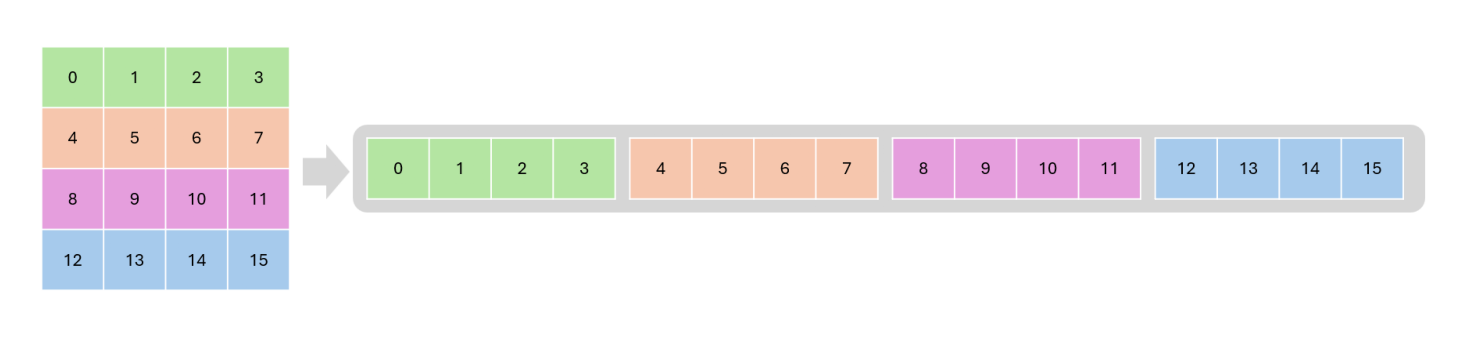

In [214]:
# HIDE CODE
img = plt.imread('luto/tools/Manual_jupyter_books/asset/fig_2d_to_1d.png')
plt.figure(figsize=(5, 5), dpi=300)
plt.axis('off')
plt.imshow(img)
plt.tight_layout()

In [15]:
# REMOVE

# Convert the `AGEC_CROPS` data to 2D xarray
agec_crops_xr = []
for col in data.AGEC_CROPS.columns:
    series = data.AGEC_CROPS[col]
    series_xr = arr_to_xr(data, series).expand_dims({
        'Type': [col[0]], 
        'lm': [col[1]], 
        'lu': [col[2]]
    })
    agec_crops_xr.append(series_xr)

# Combine the xarray objects
agec_crops_xr = xr.combine_by_coords(agec_crops_xr)

# Get the data for the given land-use
agec_crops_xr_lu = agec_crops_xr.sel(lu=lu_desc)

In [16]:
# REMOVE

# Helper function to plot the quantity matrices
def plot_dry_irr(dry_irr, irr_arr):

    # Create a figure and a set of subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

    # Plot the maps side by side
    dry_irr.plot(vmin=dry_irr.min(), vmax=dry_irr.max(), ax=axs[0])
    irr_arr.plot(vmin=irr_arr.min(), vmax=irr_arr.max(), ax=axs[1])

    # Optionally, adjust the layout
    plt.tight_layout()

Now for the purpose of intuitive understanding, we will convert the 1D array of yield data back to 2D, and plot it below.

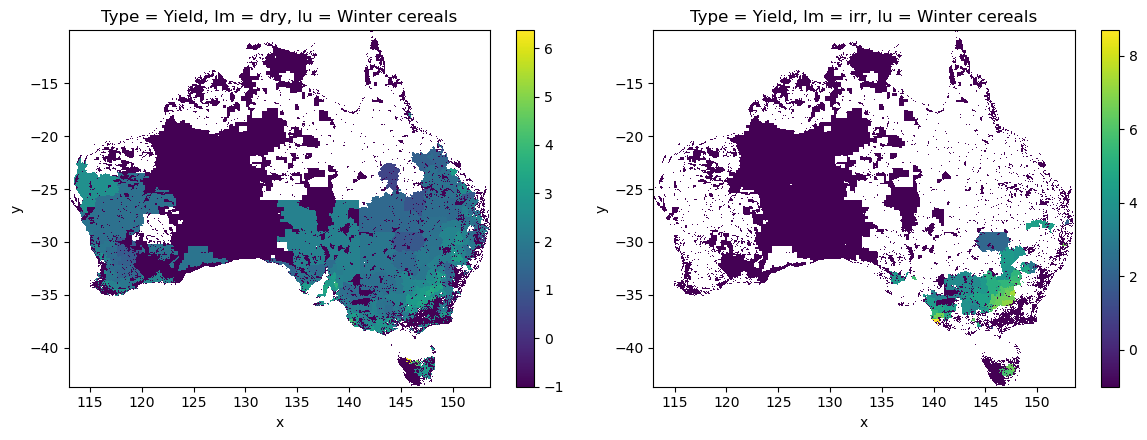

In [17]:
# HIDE CODE

# Get the yield for the given land-use
p_dry = agec_crops_xr_lu.sel(Type='Yield', lm='dry').drop_vars('spatial_ref')
p_irr = agec_crops_xr_lu.sel(Type='Yield', lm='irr').drop_vars('spatial_ref')

plot_dry_irr(p_dry, p_irr)

From the plot, we can see there are 4 types of cells in the map: 
- white (or transparent) cells outside the continental Australia,  
- white (or transparent) cells inside the continental Australia, 
- dark purple cells (with -1 value) covers the Non-Agricultural Land-use (water, desert, urban, etc.).
- colorful cells with values >= 0 and convey physical information (yield in this case).

One important fact about these 2D maps is that even though we are only interested in the yield data, the computer still needs to store the white (transparent) cells. A quick look at these maps suggests that more than half of the storage space is used for meaningless information, which is inefficient. To address this waste, LUTO uses several masks to filter out unnecessary data and cells. The steps LUTO takes to remove this unnecessary data are outlined below.

First, LUTO removes cells that cover the sea (outside of continental Australia) using a 'National land-use mask' (shown below). After this masking process, LUTO discards the masked cells permanently, saving 49.2% of storage space. The drawback is that is that from now on, the input data becomes a 1D vector that is hard to visualize for a human.

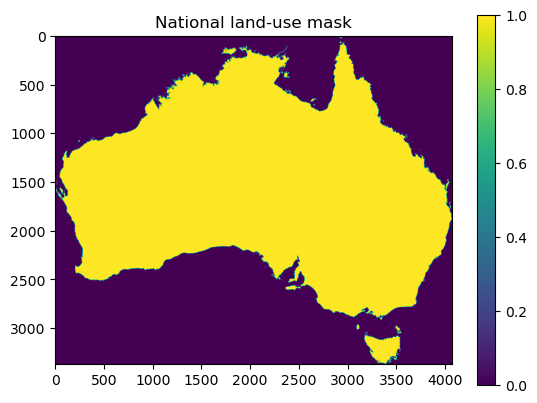

In [18]:
# HIDE CODE
plt.imshow(data.NLUM_MASK)
plt.colorbar()
plt.title('National land-use mask')
plt.show()

Next, LUTO applies a 'Land-use mask' to remove non-agricultural land uses, such as water, desert, and urban areas. By discarding these masked cells, LUTO saves an additional 39.4% of storage space. As a result, the yield map now occupies only 30.7% of the space compared to its original 2D format!

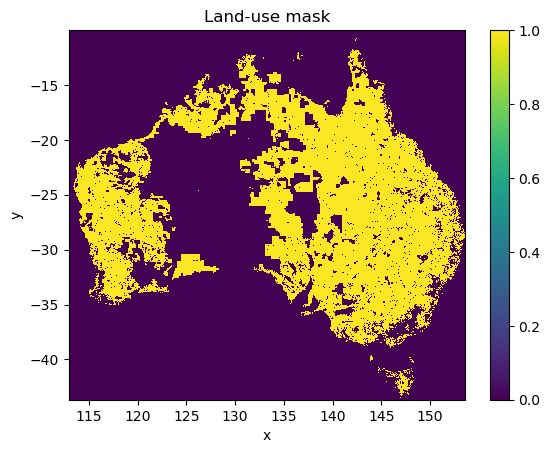

In [19]:
# HIDE CODE
lu_mask.plot()
plt.title('Land-use mask')
plt.show()

In addition to the two masks mentioned above, LUTO requires an 'exclusion mask' specifically for winter cereal. This mask identifies areas that are suitable or not suitable for cultivating winter cereal. LUTO uses a straightforward approach to determine suitability: for each SA2 region, if winter cereal was grown there in 2010, the entire region is considered suitable for future planting. Otherwise, the region is excluded from winter cereal cultivation. In this manual, we will sum up all the winter cereal cells in each [SA2](https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/main-structure-and-greater-capital-city-statistical-areas/statistical-area-level-2) region and create a plot to visualize this concept.

In [20]:
# REMOVE

sa2 = gpd.read_file('luto/tools/Manual_jupyter_books/asset/sa2_2011_aus/SA2_2011_AUST_continental_simplified.shp')

# Get the sum of pixels for each SA2 region
lu_dry_bool = np.where(lu_arr_dry.values == 1, 1, 0)
lu_irr_bool = np.where(lu_arr_irr.values == 1, 1, 0)

lu_dry_sa2_sum = zonal_stats(sa2, lu_dry_bool, affine=lu_arr_dry.rio.transform(), nodata=0, stats='sum')
lu_irr_sa2_sum = zonal_stats(sa2, lu_irr_bool, affine=lu_arr_irr.rio.transform(), nodata=0, stats='sum')

sa2['dry_count'] = [x['sum'] for x in lu_dry_sa2_sum]
sa2['irr_count'] = [x['sum'] for x in lu_irr_sa2_sum]


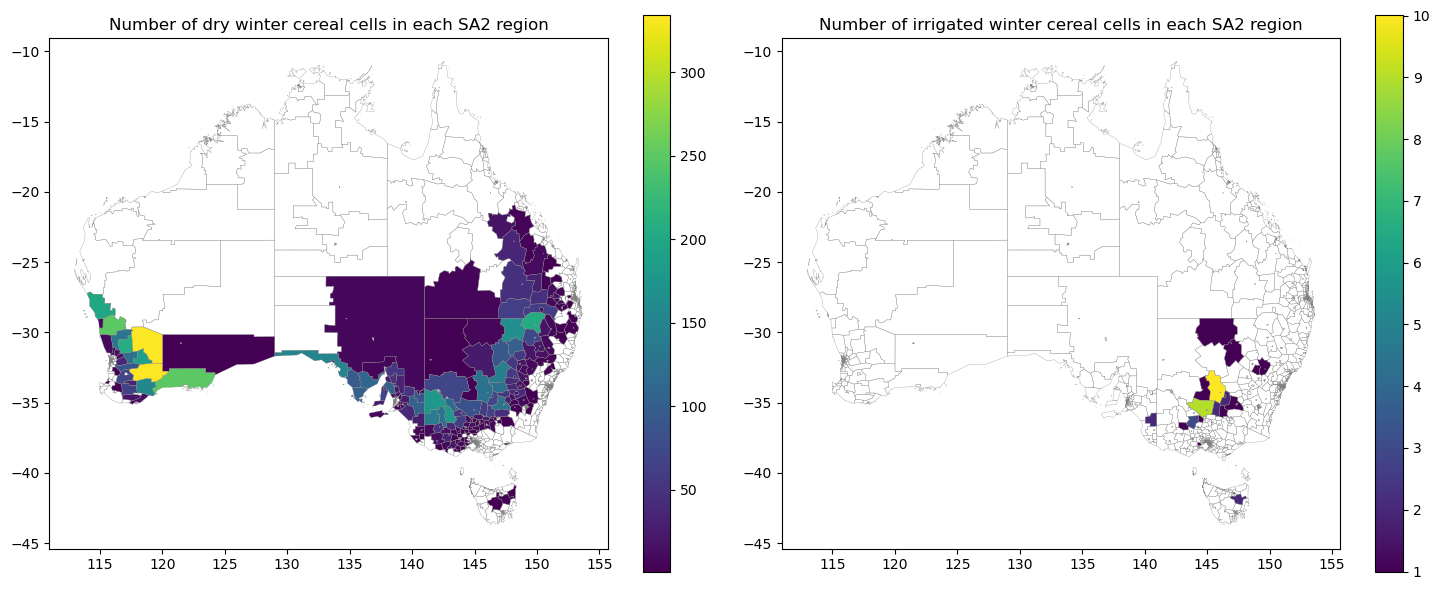

In [21]:
# HIDE CODE
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot for dry_count
sa2.plot(ax=ax[0], column='dry_count', legend=True)
sa2.plot(ax=ax[0], color='none', edgecolor='grey', linewidth=0.2)
ax[0].set_title('Number of dry winter cereal cells in each SA2 region')

# Plot for irr_count
sa2.plot(ax=ax[1], column='irr_count', legend=True)
sa2.plot(ax=ax[1], color='none', edgecolor='grey', linewidth=0.2)
ax[1].set_title('Number of irrigated winter cereal cells in each SA2 region')

plt.tight_layout()
plt.show()

Using this exclusion map, we will fill cells within a white SA2 region (where no winter cereal was found) with `NaN` values. Unlike the 'National land-use mask' or the 'Land-use mask,' the exclusion mask does not remove these cells but instead flags them as 'unsuitable' for winter cereal cultivation.

```{warning}
We noticed that some SA2 regions have only a few winter cereal plantations but cover a large area that is not suitable for winter cereal's cultivation. This is a known issue in LUTO and will be fixed in the near future.
```

### Resfactoring data to allow for coarse processing

By using masks, we reduce the input data size to about one-third of its original size, which is a significant improvement but still not sufficient. Without further reducing the input data's sizes, LUTO would require approximately 250 GB of memory and 8 hours (depending on your CPU) to process a single year. This means it would take nearly two weeks to simulate agricultural land use for the period from 2010 to 2050!

Because LUTO operates natively at a spatial resolution of approximately 1 km × 1 km, we provide an option to adjust this resolution using the `RESFACTOR` parameter in the `settings.py` file. For example, if we set 'RESFACTOR = 5', LUTO will use the central cell of each ~5 km × 5 km square to simulate land-use change, effectively running LUTO at a ~5 km × 5 km spatial resolution. With this coarser resolution, it takes only about 20 minutes to complete the simulation for a single year and around 15 hours to process the period from 2010 to 2050. This approach provides an acceptable approximation despite some loss of spatial granularity.

```{note}
Resfactoring is applied after the masking process, so the actual implementation is more complex than simply "taking the center cell out of a square." For detailed information, please refer to the [code](https://github.com/land-use-trade-offs/luto-2.0/blob/c312086b4b3a3f7d2630a1d1d9d05dd9fe9a86c9/luto/data.py#L197).
```

## Visulizing the data

### Climate change impacts

Current studies predict climate change under various scenarios. To allow users to choose their preferred prediction, LUTO provides a `luto.settings` file that specifies the available options. For climate change impact, the available selections are `rcp` and `CO2_FERT`:

- `rcp`: Representative Concentration Pathway, options include ['rcp2p6', 'rcp4p5', 'rcp6p0', 'rcp8p5'].
- `CO2_FERT`: CO2 fertilization effects, options include ['on', 'off'].

In [22]:
# REMOVE

# Convert the `AGEC_CROPS` data to 2D xarray
cci_crops_xr = []
for col in data.CLIMATE_CHANGE_IMPACT.columns:
    series = data.CLIMATE_CHANGE_IMPACT[col]
    series_xr = arr_to_xr(data, series).expand_dims({
        'lm': [col[0]], 
        'lu': [col[1]], 
        'year': [col[2]]
    })
    cci_crops_xr.append(series_xr)

# Combine the xarray objects
cci_crops_xr = xr.combine_by_coords(cci_crops_xr)


# Append ones as the climate change impact in year 2010
cci_ones_dry = cci_crops_xr.sel(lm=['dry'], year=[2020])
cci_ones_dry.data = np.ones_like(cci_ones_dry.data)
cci_ones_dry.coords['year'] = [2010]
cci_ones_irr = cci_crops_xr.sel(lm=['irr'], year=[2020])
cci_ones_irr.data = np.ones_like(cci_ones_irr.data)
cci_ones_irr.coords['year'] = [2010]
cci_crops_xr = xr.combine_by_coords([cci_crops_xr, cci_ones_dry, cci_ones_irr])


# Get the data for the given land-use
cci_crops_xr_lu = cci_crops_xr.sel(lu=lu_desc)
# Linearly interpolate the data to 2010-2100
cci_crops_xr_lu = cci_crops_xr_lu.interp(year=range(2010, 2101), method='linear', kwargs={"fill_value": "extrapolate"})

In this manual, we selected the climate impact for the `settings.rcp == 'rcp4p5'` scenario and plotted it below. The plot indicates that, by 2050, climate change is expected to have a positive impact on winter cereal production. Additionally, note that this impact multiplier is applied only within the 'suitable zones,' meaning we have intentionally excluded winter cereal cultivation from areas deemed unsuitable.

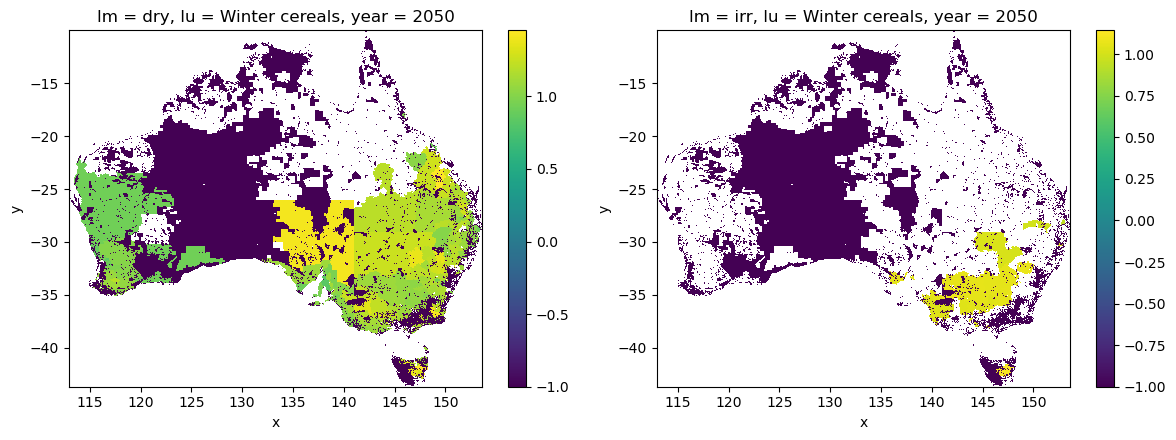

In [23]:
# HIDE CODE

# Get the data for the given year
cci_dry = cci_crops_xr_lu.sel(lm='dry', year=year_target).drop_vars('spatial_ref')
cci_irr = cci_crops_xr_lu.sel(lm='irr', year=year_target).drop_vars('spatial_ref')

plot_dry_irr(cci_dry, cci_irr)

In [24]:
# REMOVE


# Functiont to read the climate change impact data and convert it to xarray
def read_cc_impact(rcp, co2, lu=lu_desc):
    df = pd.read_hdf(os.path.join('input', "climate_change_impacts_" + rcp + "_CO2_FERT_" + co2 + ".h5")).iloc[data.MASK]
    df = df.loc[:, (slice(None), lu_desc, slice(None))]
    df = df.unstack().reset_index().rename(columns={'level_0': 'water_supply', 'level_1': 'Land-use', 'level_2': 'Year', 0: 'Value'})
    
    # Convert the data to xarray
    df_xr = []
    for col, df_ in df.groupby(['water_supply', 'Land-use', 'Year']):
        arr_xr = arr_to_xr(data, df_['Value']).expand_dims({
            'lm': [col[0]],
            'lu': [col[1]],
            'year': [col[2]]
        })
        df_xr.append(arr_xr)
    df_xr = xr.combine_by_coords(df_xr)

    # Append ones as the climate change impact in year 2010
    ones_xr = df_xr.sel(year=[2020]) / df_xr.sel(year=[2020])
    ones_xr.coords['year'] = [2010]
    df_xr = xr.combine_by_coords([df_xr, ones_xr])

    # Interpolate the data to 2010-2100
    df_xr = df_xr.interp(year=list(df_xr['year'].values) + [2100], method='linear', kwargs={"fill_value": "extrapolate"})
    
    # Add rcp and co2_fert as coordinates
    df_xr = df_xr.expand_dims({'rcp': [rcp], 'co2_fert': [co2]})
        
    return df_xr

In [ ]:
# REMOVE

# Read the climate change impact data
rcps = ['rcp2p6', 'rcp4p5', 'rcp6p0', 'rcp8p5']
co2_fert = ['on', 'off']

cc_impacts = []
for rcp,co2 in tqdm(product(rcps, co2_fert)):
    arr = read_cc_impact(rcp, co2)
    cc_impacts.append(arr)
    
cc_impacts = xr.combine_by_coords(cc_impacts)

If you're curious about the impact of climate change under different RCP scenarios and CO2 Fertilization effects, we've prepared a plot below that illustrates the mean values of all climate change multipliers. The plot reveals significant differences in winter cereal yields under dry and irrigated water supplies. Additionally, note the opposite trends in yield predictions depending on the CO2 fertilization effects. This highlights the importance of carefully selecting the appropriate `RCP` and `CO2_fert` parameters in LUTO, as different assumptions can lead to vastly different outcomes in future agricultural productivity.

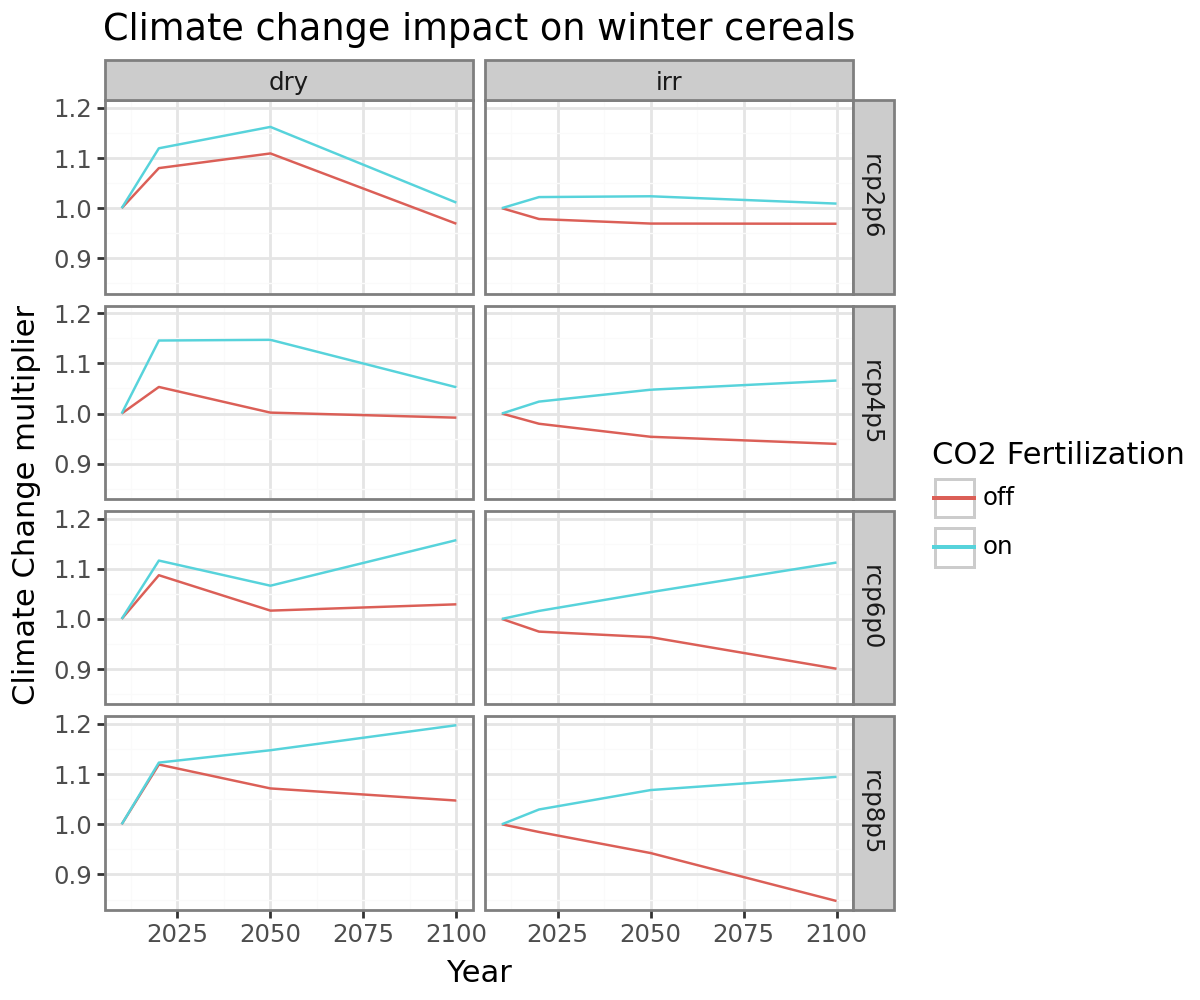

In [21]:
# HIDE CODE

cc_impacts_lu = cc_impacts * lu_mask.where(lu_mask == 1)
cc_impacts_lu_stats = cc_impacts_lu.mean(dim=['x', 'y']).to_dataframe(name='cc_multiplier').reset_index()

(p9.ggplot(cc_impacts_lu_stats)
     + p9.geom_line(p9.aes(x='year', y='cc_multiplier', color='co2_fert'))
     + p9.facet_grid('rcp ~ lm')
     + p9.theme_bw()
     + p9.labs(title='Climate change impact on winter cereals', x='Year', y='Climate Change multiplier', color='CO2 Fertilization')
)

### Economic data

The economic data includes both costs and revenue for agricultural products. Revenue is recorded as a single unit price ($/tonne), while costs come from various sources. LUTO calculates the economic cost of producing agricultural commodities using factors such as 'area cost,' 'fixed depreciation cost,' 'fixed labor cost,' and 'quantity cost.'

To extract the revenue of dryland winter cereal, we can use `rev_lu_dry = data.AGEC_CROPS.loc[:,('P1', 'dry', 'Winter cereals')]`. Below is the how it looks with a print function.

In [58]:
# REMOVE
rev_lu_dry = data.AGEC_CROPS.loc[:,('P1', 'dry', 'Winter cereals')].values.astype(np.float32)
rev_lu_irr = data.AGEC_CROPS.loc[:,('P1', 'irr', 'Winter cereals')].values.astype(np.float32)

rev_lu_dry_xr = arr_to_xr(data, rev_lu_dry).expand_dims({'lm': ['dry'], 'lu': [lu_desc]}).drop_vars('spatial_ref')
rev_lu_irr_xr = arr_to_xr(data, rev_lu_irr).expand_dims({'lm': ['irr'], 'lu': [lu_desc]}).drop_vars('spatial_ref')

We can plot the revenue data ($/ha) on a map, as shown below. You'll notice that the revenue for both dryland and irrigated land is the same.

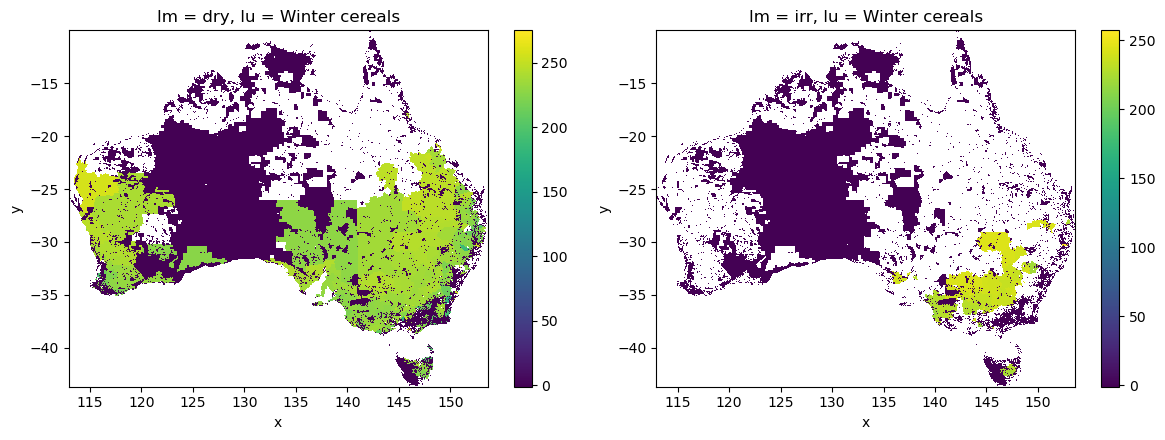

In [60]:
# HIDE CODE
plot_dry_irr(rev_lu_dry_xr, rev_lu_irr_xr)

We can plot different costs as well.

In [64]:
# REMOVE

cost_lu_AC_dry = data.AGEC_CROPS.loc[:,('AC', 'dry', 'Winter cereals')].values.astype(np.float32)
cost_lu_AC_irr = data.AGEC_CROPS.loc[:,('AC', 'irr', 'Winter cereals')].values.astype(np.float32)

cost_lu_FDC_dry = data.AGEC_CROPS.loc[:,('FDC', 'dry', 'Winter cereals')].values.astype(np.float32)
cost_lu_FDC_irr = data.AGEC_CROPS.loc[:,('FDC', 'irr', 'Winter cereals')].values.astype(np.float32)

cost_lu_FLC_dry = data.AGEC_CROPS.loc[:,('FLC', 'dry', 'Winter cereals')].values.astype(np.float32)
cost_lu_FLC_irr = data.AGEC_CROPS.loc[:,('FLC', 'irr', 'Winter cereals')].values.astype(np.float32)

cost_lu_FOC_dry = data.AGEC_CROPS.loc[:,('FOC', 'dry', 'Winter cereals')].values.astype(np.float32)
cost_lu_FOC_irr = data.AGEC_CROPS.loc[:,('FOC', 'irr', 'Winter cereals')].values.astype(np.float32)

cost_lu_QC_dry = data.AGEC_CROPS.loc[:,('QC', 'dry', 'Winter cereals')].values.astype(np.float32)
cost_lu_QC_irr = data.AGEC_CROPS.loc[:,('QC', 'irr', 'Winter cereals')].values.astype(np.float32)

cost_lu_all_dry = cost_lu_AC_dry + cost_lu_FDC_dry + cost_lu_FLC_dry + cost_lu_FOC_dry + cost_lu_QC_dry
cost_lu_all_irr = cost_lu_AC_irr + cost_lu_FDC_irr + cost_lu_FLC_irr + cost_lu_FOC_irr + cost_lu_QC_irr


# Convert to xarray
cost_lu_AC_dry_xr = arr_to_xr(data, cost_lu_AC_dry).expand_dims({'lm': ['dry'], 'lu': [lu_desc]}).drop_vars('spatial_ref')
cost_lu_AC_irr_xr = arr_to_xr(data, cost_lu_AC_irr).expand_dims({'lm': ['irr'], 'lu': [lu_desc]}).drop_vars('spatial_ref')

cost_lu_FDC_dry_xr = arr_to_xr(data, cost_lu_FDC_dry).expand_dims({'lm': ['dry'], 'lu': [lu_desc]}).drop_vars('spatial_ref')
cost_lu_FDC_irr_xr = arr_to_xr(data, cost_lu_FDC_irr).expand_dims({'lm': ['irr'], 'lu': [lu_desc]}).drop_vars('spatial_ref')

cost_lu_FLC_dry_xr = arr_to_xr(data, cost_lu_FLC_dry).expand_dims({'lm': ['dry'], 'lu': [lu_desc]}).drop_vars('spatial_ref')
cost_lu_FLC_irr_xr = arr_to_xr(data, cost_lu_FLC_irr).expand_dims({'lm': ['irr'], 'lu': [lu_desc]}).drop_vars('spatial_ref')

cost_lu_FOC_dry_xr = arr_to_xr(data, cost_lu_FOC_dry).expand_dims({'lm': ['dry'], 'lu': [lu_desc]}).drop_vars('spatial_ref')
cost_lu_FOC_irr_xr = arr_to_xr(data, cost_lu_FOC_irr).expand_dims({'lm': ['irr'], 'lu': [lu_desc]}).drop_vars('spatial_ref')

cost_lu_QC_dry_xr = arr_to_xr(data, cost_lu_QC_dry).expand_dims({'lm': ['dry'], 'lu': [lu_desc]}).drop_vars('spatial_ref')
cost_lu_QC_irr_xr = arr_to_xr(data, cost_lu_QC_irr).expand_dims({'lm': ['irr'], 'lu': [lu_desc]}).drop_vars('spatial_ref')

cost_lu_all_dry_xr = arr_to_xr(data, cost_lu_all_dry).expand_dims({'lm': ['dry'], 'lu': [lu_desc]}).drop_vars('spatial_ref')
cost_lu_all_irr_xr = arr_to_xr(data, cost_lu_all_irr).expand_dims({'lm': ['irr'], 'lu': [lu_desc]}).drop_vars('spatial_ref')

In [65]:
data.AGEC_CROPS.columns.levels

FrozenList([['AC', 'FDC', 'FLC', 'FOC', 'P1', 'QC', 'WP', 'WR', 'Yield'], ['dry', 'irr'], ['Apples', 'Citrus', 'Cotton', 'Grapes', 'Hay', 'Nuts', 'Other non-cereal crops', 'Pears', 'Plantation fruit', 'Rice', 'Stone fruit', 'Sugar', 'Summer cereals', 'Summer legumes', 'Summer oilseeds', 'Tropical stone fruit', 'Vegetables', 'Winter cereals', 'Winter legumes', 'Winter oilseeds']])

# Apply Constraints

## Commodity production 

Now we can extend winter cereal's yield to 2050 by multiplying its yield in 2010 with climate change's impact in 2050 (in the below map).

In [22]:
# REMOVE
yr_idx = year_target - year_begin
# Get the quantity matrices
q_mrp = get_quantity_matrices(data, yr_idx).astype(np.float32)          # t/cell
q_mrp_xr = mrj_to_xr(data, q_mrp).expand_dims({'year': [year_target]})  

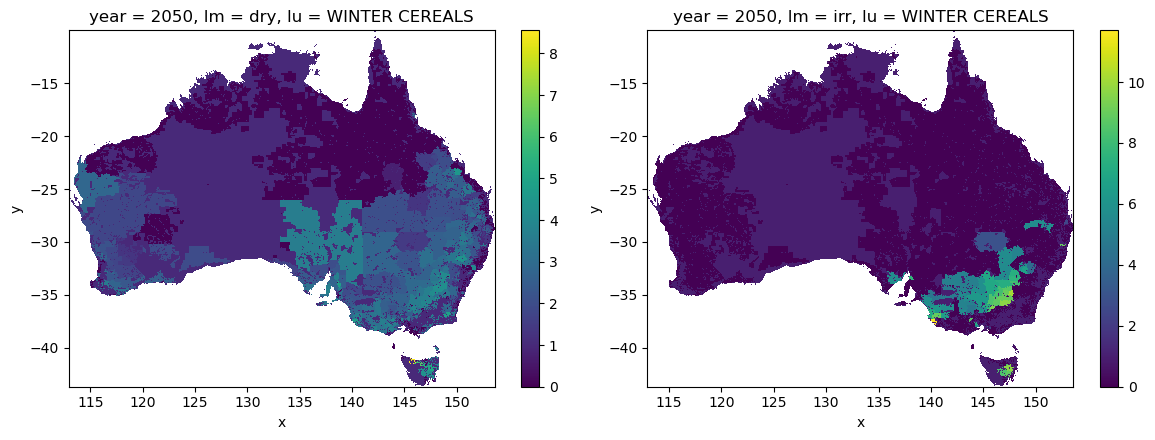

In [23]:
# HIDE CODE
q_lu_target = q_mrp_xr / lu_area  # t/ha

q_dry_target = q_lu_target.sel(lm='dry', lu=lu_desc.upper(), year=year_target).drop_vars('spatial_ref')
q_irr_target = q_lu_target.sel(lm='irr', lu=lu_desc.upper(), year=year_target).drop_vars('spatial_ref')
plot_dry_irr(q_dry_target, q_irr_target)

Let's use winter cereal's spatial distribution in 2010 and its yield of 2050 to get the production in 2050. If the result is larger than demand, that means we do not need to do anything to winter cereal; otherwise, we need to rearrange its spatial distribution to meet the demand of 2050.

```{note}
To get the production, we simply need to apply below function: `production` = `land-use map` * `yield map`. However, there are a few things need to keep in mind:
- The `land-use map` is just a spatial indication of how the land is used. It does not have any physical meaning attached.
- `yield map` is a physical indication of 'tonnes/hactor'
- We need to assign the `area (hactor)/cell` information to land-use map so that the result will be a production (`tonnes/cell`)
```


LUTO has a `data.REAL_AREA` variable that stores the true area (hactor) for each cell. In order to get winter cereal's production, we need to include this data in the formulation `production (tonne/ha)` = `land-use map` * `area map (ha/cell)` * `yield map (tonne/ha)` for a correct calculation. Have a think about why the area in the north part is larger than the south (LUTO uses the 'Geocentric Datum of Australia (GDA) 1994 coordinate system).

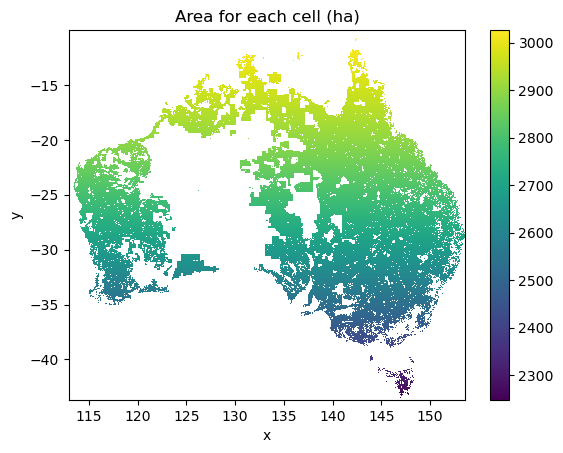

In [24]:
# HIDE CODE
lu_area.where(lu_mask == 1).plot()
plt.title('Area for each cell (ha)')
plt.show()

In [25]:
# HIDE CODE

# Calculate the total quantity for each water supply
q_dry_total = lu_arr_dry.values * lu_area.values * q_dry_target.values * lu_mask.values      
q_dry_total = np.nansum(q_dry_total) / 1e6          # million t               

q_irr_total = lu_arr_irr.values * lu_area.values * q_irr_target.values * lu_mask.values   
q_irr_total = np.nansum(q_irr_total) / 1e6          # million t 

# Get the total quantity for the given land-use
q_total = q_dry_total + q_irr_total                 # million t       

print(f'Total quantity for {lu_desc} in {year_target}: {q_total:.2f} million tonnes.') 

Total quantity for Winter cereals in 2050: 51.00 million tonnes.


Recall that the demand for winter cereal will be 77.31 million tonness in 2050 and there will be a 26.31 million metric tons shortage based on winter cereal's 2010 spatial distribution. Therefore, we need to increase winter cereal's plantation to fill this gap.

To make it simple, let's gradually close the demand gap by randomly adding cells to the winter cereal's map of 2010:
1) Randomly select and add 10 cells to both dry and irrigated winter cereal map for 2010
2) Reduce the demand gap by subtracting the production from these 10 newly added cells
3) If the demand was closed, then stop this random cell addition
4) If the demand still exist, then start another round of random cell addition

```{note}
In this example, we use the random cell addition method to simplify the process of finding a solution. In LUTO, we utilize a commercial solver called [Gurobi](https://www.gurobi.com/) to find the optimal solution. The detailed implementation can be found [here](https://github.com/land-use-trade-offs/luto-2.0/blob/master/luto/solvers/solver.py).
```

In [26]:
# REMOVE

# Get the available land for the given land-use
lu_arr_dry_aval = (lu_arr_dry == 0) * (lu_arr_irr != 1) * (q_dry_target > 0)
lu_arr_irr_aval = (lu_arr_irr == 0) * (lu_arr_dry != 1) * (q_irr_target > 0)

In [27]:
# REMOVE

def rand_reduce_gap(in_dry, in_irr, q_dry, q_irr, gap, chunk_size=10):

    # Get the row/col for the non-zero values
    row_dry, col_dry = np.nonzero(in_dry)
    row_irr, col_irr = np.nonzero(in_irr)

    # Get the index for the non-zero values
    idx_dry = list(range(len(row_dry)))
    idx_irr = list(range(len(row_irr)))
    
    # Initialize the selected index
    sel_idx_dry = []
    sel_idx_irr = []
    
    # Loop until the gap is closed
    while gap>= 0:
        if len(idx_dry) <= chunk_size or len(idx_irr) <= chunk_size:
            print('Not enought land for the meeting the production gap.')
            break
        
        sel_dry = np.random.choice(idx_dry, chunk_size, replace=False)
        sel_irr = np.random.choice(idx_irr, chunk_size, replace=False)
        
        [idx_dry.remove(i) for i in sel_dry]
        [idx_irr.remove(i) for i in sel_irr]
        
        sel_idx_dry.extend(sel_dry)
        sel_idx_irr.extend(sel_irr)
        
        gap -= np.nansum(q_dry.values[row_dry.values[sel_dry], col_dry.values[sel_dry]])
        gap -= np.nansum(q_irr.values[row_irr.values[sel_irr], col_irr.values[sel_irr]])
        
    # Get the pred array
    pred_arr_dry = lu_arr_dry.copy()
    pred_arr_irr = lu_arr_irr.copy()
    
    pred_arr_dry.values[row_dry.values[sel_idx_dry], col_dry.values[sel_idx_dry]] = 2
    pred_arr_irr.values[row_irr.values[sel_idx_irr], col_irr.values[sel_idx_irr]] = 2
           
    return pred_arr_dry, pred_arr_irr

In [28]:
# REMOVE

# Randomly select from available land to meet the production gap
from joblib import Parallel, delayed 
from tqdm.auto import tqdm  

n_runs = 100     

gap = (demand_vol - q_total) * 1e6              # tonnes
q_dry_cell = q_dry_target * lu_area             # t/cell
q_irr_cell = q_irr_target * lu_area             # t/cell

para_obj = Parallel(n_jobs=20, return_as='generator')
tasks = (delayed(rand_reduce_gap)(lu_arr_dry_aval, lu_arr_irr_aval, q_dry_cell, q_irr_cell, gap, chunk_size=10) for _ in range(n_runs))
results = [i for i in tqdm(para_obj(tasks), total=n_runs)]

  0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
# REMOVE

# Combine all results to one xarray object
pred_arr_xr = []
for i,arr in enumerate(results):
    dry_arr = arr[0].expand_dims({'run': [i], 'lm':['dry']},)
    irr_arr = arr[1].expand_dims({'run': [i], 'lm':['irr']},)
    pred_arr_xr.append(dry_arr)
    pred_arr_xr.append(irr_arr)

# Combine the xarray objects
pred_arr_xr = xr.combine_by_coords(pred_arr_xr)   

Here, we repeat the random process 100 times so that we can illustrate how LUTO finds the best solution under various constraints and objective functions. Below are the simulated results stored in a `xarray.DataArray`, we can see that `run: 100` indicates there are 100 runs, `lm: 2` means each run includes a dry and an irrigated result, and `x` and `y` are the height and weight of each result.

In [30]:
# HIDE CODE
pred_arr_xr['data']

<xarray.DataArray 'data' (run: 100, lm: 2, y: 673, x: 814)> Size: 438MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
...
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * run          (run) int32 400B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * lm           (lm) object 16B 'dry' 'irr'
    lu           <U14 56B 'Winter cereals'
  * x            (x) float64 7kB 113.0 113.0 113.0 113.1 ... 153.5 153.6 153.6
  * y            (y) float64 5kB -10.04 -10.09 -10.14 ... -43.54 -43.59 -43.64
    spatial_ref  int32 4B 0

Let's plot the first solution (run = 0) and compare it with the original land-use map. We can see the randomly added pixel of dryland winter cereal scattered across south Australia, and the irrigated winter cereal is more closely aggregated around in the sourtheast. Remember, this is just one solution out of the 100 runs. The question is: how do you find the best one? The general idea is that we will calculate the water consumption, GHG emissions, and biodiversity contribution to exclude solutions we can't accept, and finally use revenue/cost to get the solution with the minimized cost or maximized profit. 

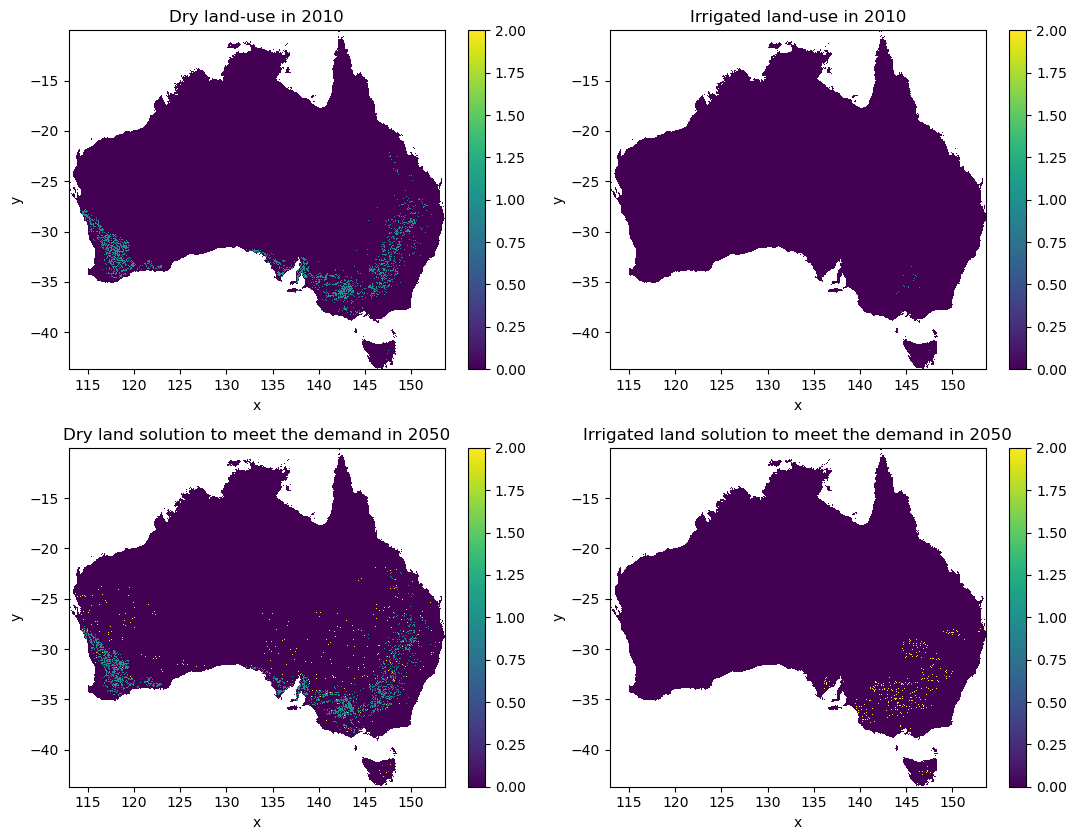

In [31]:
# HIDE CODE

fig, axs = plt.subplots(2,2, figsize=(11, 8.5), dpi=100)
axs = np.array(axs).flatten()

(lu_arr_dry * lu_mask).plot(ax=axs[0], vmax=2)
axs[0].set_title('Dry land-use in 2010')

(lu_arr_irr * lu_mask).plot(ax=axs[1], vmax=2)
axs[1].set_title('Irrigated land-use in 2010')

(pred_arr_xr['data'].sel(lm='dry', run=0) * lu_mask).plot(ax=axs[2])
axs[2].set_title('Dry land solution to meet the demand in 2050')

(pred_arr_xr['data'].sel(lm='irr', run=0) * lu_mask).plot(ax=axs[3])
axs[3].set_title('Irrigated land solution to meet the demand in 2050')

plt.tight_layout()


## Water Requirement

In [32]:
# REMOVE
wr_mrj = get_wreq_matrices(data, year_target - year_begin)              # ML/cell
wr_mrj_xr = mrj_to_xr(data, wr_mrj) / lu_area * lu_mask                 # ML/ha

wr_mrj_xr_lu = wr_mrj_xr.sel(lu=lu_desc)

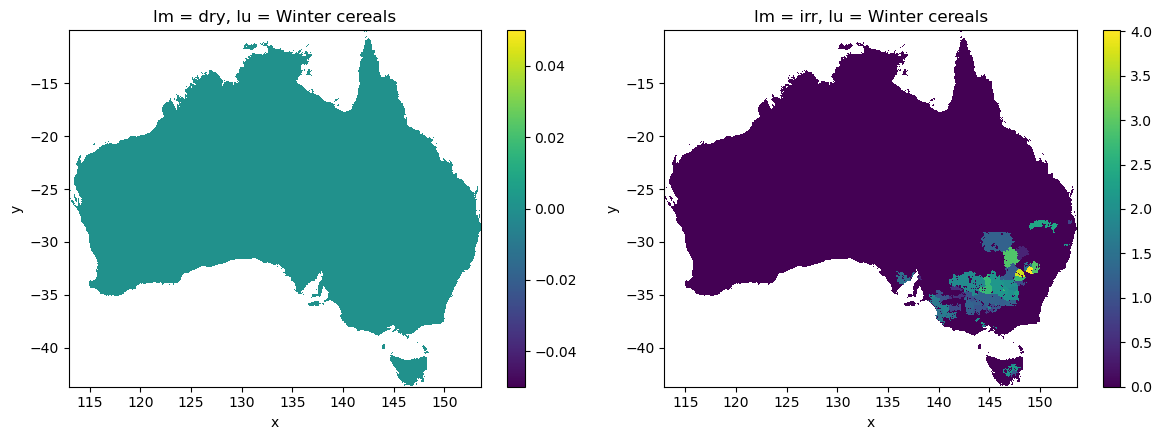

In [33]:
# HIDE CODE
wr_dry = wr_mrj_xr_lu.sel(lm='dry').drop_vars('spatial_ref')
wr_irr = wr_mrj_xr_lu.sel(lm='irr').drop_vars('spatial_ref')

plot_dry_irr(wr_dry, wr_irr)

## GHG emmisions

In [46]:
# REMOVE

# Convert the `AGEC_CROPS` data to 2D xarray
agghg_crops_xr = []
for col in data.AGGHG_CROPS.columns:
    series = data.AGGHG_CROPS[col]
    series_xr = arr_to_xr(data, series).expand_dims({
        'Type': [col[0]], 
        'lm': [col[1]], 
        'lu': [col[2]]
    })
    agghg_crops_xr.append(series_xr)

# Combine the xarray objects
agghg_crops_xr = xr.combine_by_coords(agghg_crops_xr)            # kg/ha

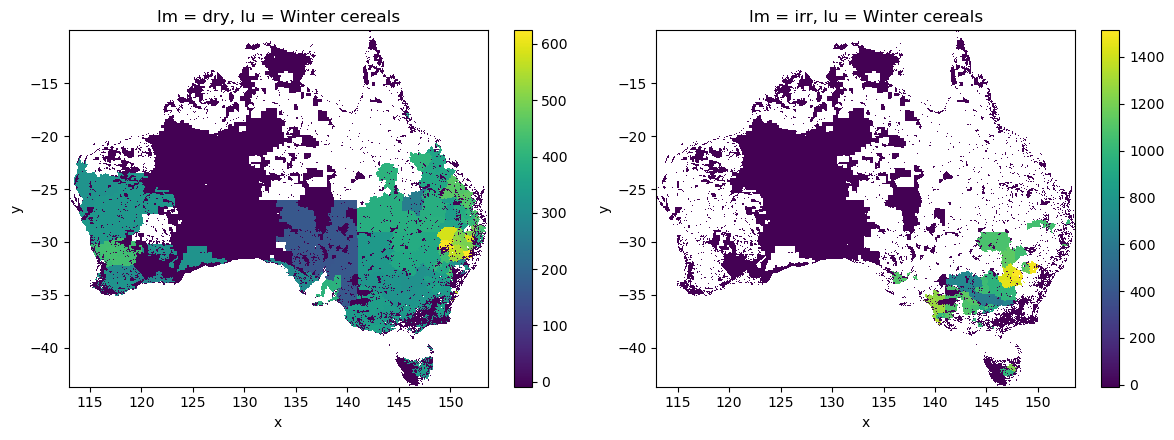

In [47]:
# HIDE CODE
agghg_crops_xr_lu = agghg_crops_xr.sel(lu=lu_desc).sum(dim=['Type'], skipna=False)    # kg/ha
ghg_dry = agghg_crops_xr_lu.sel(lm='dry').drop_vars('spatial_ref') 
ghg_irr = agghg_crops_xr_lu.sel(lm='irr').drop_vars('spatial_ref') 

plot_dry_irr(ghg_dry, ghg_irr)

## Cost and Revenue

In [ ]:
# REMOVE

# Area Cost, Fixed Depreciation Cost, Fixed Labour Cost, Fixed Operating Cost   
c_fix = agec_crops_xr_lu.sel(Type=['AC', 'FDC', 'FLC', 'FOC'])       # $/ha

# Quantity Cost
c_q = agec_crops_xr_lu.sel(Type='QC') * q_lu_target                  # $/ha

# Water Cost
c_wr = agec_crops_xr_lu.sel(Type='WP') * wr_mrj_xr_lu                # $/ha          

# Revenue
r = agec_crops_xr_lu.sel(Type='P1') * q_lu_target                    # $/ha   


###########    Total Cost    ###########
c_total = c_fix.sum(dim='Type') + c_q + c_wr                         # $/ha  

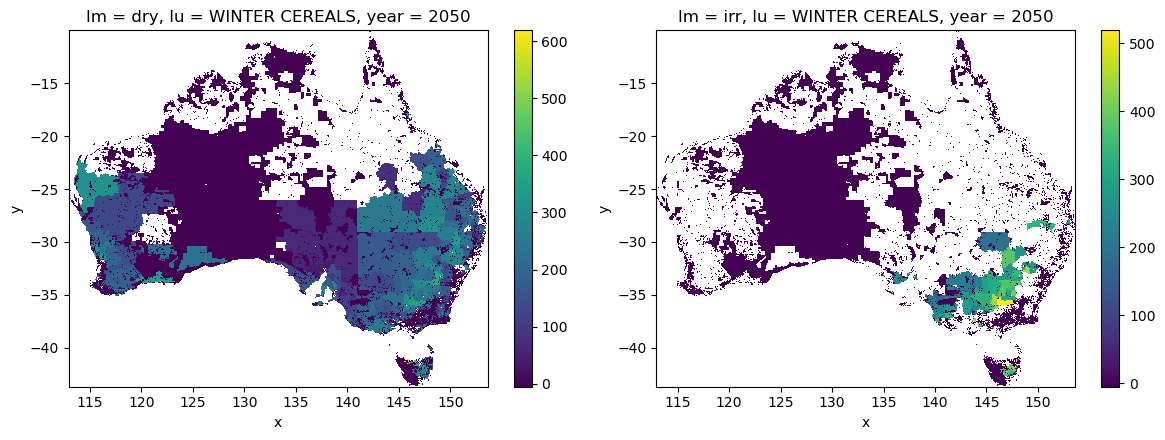

In [ ]:
# HIDE CODE

c_arr = c_total.sel(lu=lu_desc.upper()).drop_vars('spatial_ref')

# REMOVE
c_dry = c_arr.sel(lm='dry')
c_irr = c_arr.sel(lm='irr')

plot_dry_irr(c_dry, c_irr)

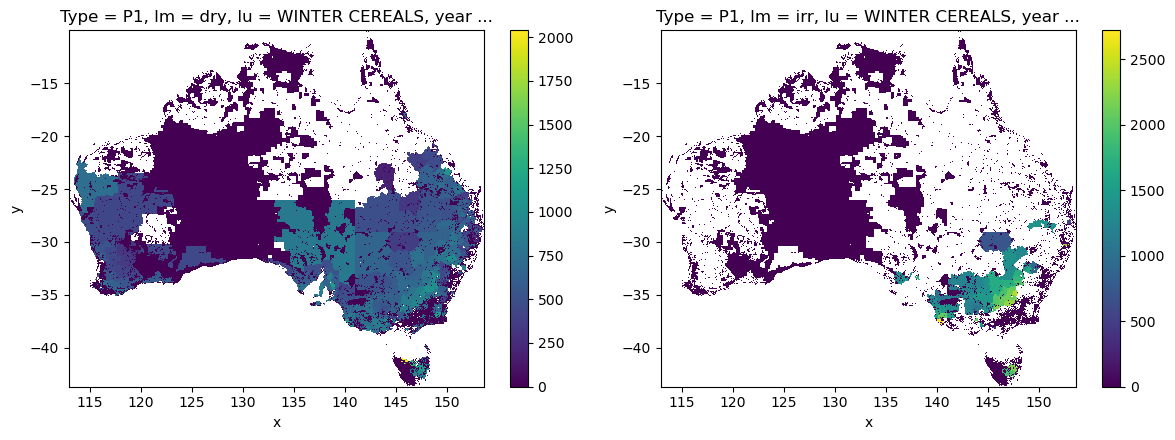

In [ ]:
# HIDE CODE

r_dry = r.sel(lm='dry', lu=lu_desc.upper()).drop_vars('spatial_ref')
r_irr = r.sel(lm='irr', lu=lu_desc.upper()).drop_vars('spatial_ref')

plot_dry_irr(r_dry, r_irr)

## Find the optimized solution

In [48]:
# REMOVE

c_pred_xr = c_total * lu_area * pred_arr_xr
c_pred_xr_sum = c_pred_xr.sum(dim=['lm','x', 'y']) / 1e9        # billion $

r_pred_xr = r * lu_area * pred_arr_xr
r_pred_xr_sum = r_pred_xr.sum(dim=['lm','x', 'y']) / 1e9        # billion $

wr_pred_xr = wr_mrj_xr_lu * lu_area * pred_arr_xr               
wr_pred_xr_sum = wr_pred_xr.sum(dim=['lm','x', 'y']) / 1e6      # million ML

ghg_pred_xr = agghg_crops_xr_lu * lu_area * pred_arr_xr         
ghg_pred_xr_sum = ghg_pred_xr.sum(dim=['lm','x', 'y']) / 1e9    # million t

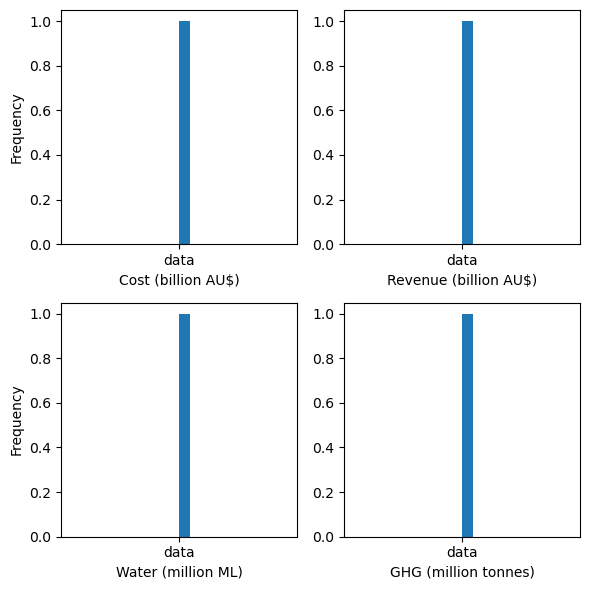

In [49]:
# HIDE CODE

fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()


axs[0].set_ylabel('Frequency')
axs[0].hist(c_pred_xr_sum, bins=20)
axs[0].set_xlabel('Cost (billion AU$)')

axs[1].hist(r_pred_xr_sum, bins=20)
axs[1].set_xlabel('Revenue (billion AU$)')

axs[2].set_ylabel('Frequency')
axs[2].hist(wr_pred_xr_sum, bins=20)
axs[2].set_xlabel('Water (million ML)')

axs[3].hist(ghg_pred_xr_sum, bins=20)
axs[3].set_xlabel('GHG (million tonnes)')


plt.tight_layout()

In [50]:
# REMOVE

# Set abitrairy water and GHG limits
ghg_lmt = 18.8           # million tonnes
water_lmt = 15           # million ML

runs_lmt = (ghg_pred_xr_sum < ghg_lmt) & (wr_pred_xr_sum < water_lmt)
runs_idx = ghg_pred_xr_sum.coords['run'].values[runs_lmt.values]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [52]:
runs_lmt

<xarray.Dataset> Size: 560B
Dimensions:      (run: 100)
Coordinates:
  * run          (run) int32 400B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
    lu           <U14 56B 'Winter cereals'
    spatial_ref  int32 4B 0
Data variables:
    data         (run) bool 100B True True True True ... True True True True

In [51]:
ghg_pred_xr_sum

<xarray.Dataset> Size: 860B
Dimensions:      (run: 100)
Coordinates:
  * run          (run) int32 400B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
    lu           <U14 56B 'Winter cereals'
    spatial_ref  int32 4B 0
Data variables:
    data         (run) float32 400B 15.63 15.61 15.67 ... 15.87 15.76 15.84

In [ ]:
# HIDE CODE

c_df = c_pred_xr_sum[runs_idx].to_dataframe(name='Cost_billion_AUD').reset_index()
r_df = r_pred_xr_sum[runs_idx].to_dataframe(name='Revenue_billion_AUD').reset_index()

c_r_df = pd.merge(c_df, r_df, on=['run'], how='inner')[['run', 'Cost_billion_AUD', 'Revenue_billion_AUD']]
c_r_df['Profit_billion_AUD'] = c_r_df['Revenue_billion_AUD'] - c_r_df['Cost_billion_AUD']
c_r_df

In [ ]:
# HIDE CODE

c_min_idx = c_r_df['Cost_billion_AUD'].argmin()
c_min_run = c_r_df['run'][c_min_idx]

p_max_idx = c_r_df['Profit_billion_AUD'].argmax()
p_max_run = c_r_df['run'][p_max_idx]

print(f'The run with the minimum cost is {c_min_run}.\nThe run with the maximum profit is {p_max_run}.')

In [ ]:
# HIDE CODE

pred_min_c = pred_arr_xr.sel(run=c_min_run)
pred_min_c_dry = pred_min_c.sel(lm='dry').drop_vars('spatial_ref')
pred_min_c_irr = pred_min_c.sel(lm='irr').drop_vars('spatial_ref')

plot_dry_irr(pred_min_c_dry, pred_min_c_irr)

In [ ]:
# HIDE CODE

pred_max_p = pred_arr_xr.sel(run=p_max_run)
pred_max_p_dry = pred_max_p.sel(lm='dry').drop_vars('spatial_ref')
pred_max_p_irr = pred_max_p.sel(lm='irr').drop_vars('spatial_ref')

plot_dry_irr(pred_max_p_dry, pred_max_p_irr)